<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-Anomaly-Detection/blob/main/Notebooks/Traffic_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [97]:
import gdown
import os
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Download dataset

In [2]:

def download_file_from_google_drive(file_id, destination):
    """
    Input: file_id (Obtained from google drive), destionation (For saving the file)
    Output: _ (Download the file in destination directory)
    """
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, destination, quiet=True)


def unzip_dataset(extraction_dir):

  """
  Input: Extraction_dir (Direction of dataset to unzip into)
  Output: _ (Exract the zip file in the given direction)
  """

  # Ensure the extraction directory exists
  os.makedirs(extraction_dir, exist_ok=True)

  # Unzip the file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_dir)




current_working_dir = os.getcwd()
destination = current_working_dir
zip_file_path = os.path.join(destination, 'dataset.zip')
file_id =  '1c3PZqvYMMwpeLXPq90hiruVadcxwW6T7' # File Id
extraction_dir = os.path.join(destination,'dataset/')

# call functions
download_file_from_google_drive(file_id, zip_file_path)
unzip_dataset(extraction_dir)

# Load Dataset

In [83]:
train_data_dir = os.path.join(destination, 'dataset/train_data.csv')
train_data_df = pd.read_csv(train_data_dir)
display(train_data_df)


,count,id
0,45.0,S312425-1
1,39.0,S312425-2
2,35.0,S312425-3
3,67.0,S312425-4
4,104.0,S312425-5
...,...,...
525595,126.0,S314147-105116
525596,108.0,S314147-105117
525597,80.0,S314147-105118
525598,91.0,S314147-105119


In [84]:
train_labels_dir = os.path.join(destination, 'dataset/train_labels.csv')
train_labels_df = pd.read_csv(train_labels_dir)
display(train_labels_df)


,label,id
0,0,S312425-1
1,0,S312425-2
2,0,S312425-3
3,0,S312425-4
4,0,S312425-5
...,...,...
525595,0,S314147-105116
525596,0,S314147-105117
525597,0,S314147-105118
525598,0,S314147-105119


In [85]:
# We can merge them
df = pd.merge(left=train_data_df, right=train_labels_df, on='id')

# Remove id column for better analysis
id = df['id']
df.drop(['id'],axis=1, inplace= True)
display(df)

,count,label
0,45.0,0
1,39.0,0
2,35.0,0
3,67.0,0
4,104.0,0
...,...,...
525595,126.0,0
525596,108.0,0
525597,80.0,0
525598,91.0,0


# EDA

In [86]:
# Check there is null value or not
df.isnull().sum()

,0
count,64
label,0


In [87]:
# Remove null
df.dropna(inplace=True)
df = df.reset_index()
df.drop(['index'],axis=1,inplace=True)

In [88]:
df.isnull().sum()

,0
count,0
label,0


As you can the number of anomalies is very small in comparision to Normal points
****************************************************************************************************
		Number of Normal Points: 525331 				Number of Anomalies: 205


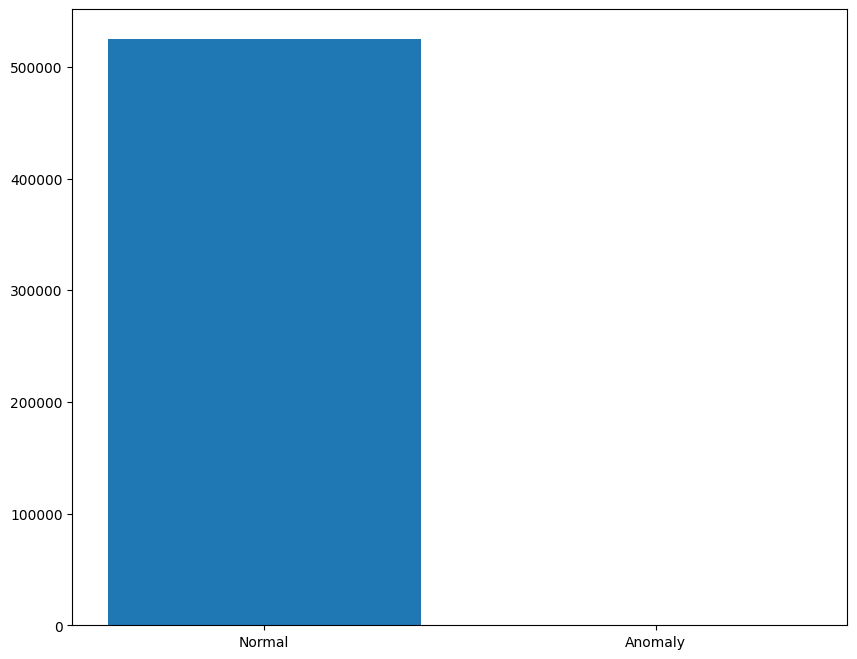

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
normal_points, anomaly_points = np.unique(df.label,return_counts=True)[1]
plt.bar(['Normal','Anomaly'],np.unique(df.label,return_counts=True)[1])
print('As you can the number of anomalies is very small in comparision to Normal points')
print('*'*100)
print('\t\tNumber of Normal Points:',normal_points,'\t\t\t\tNumber of Anomalies:', anomaly_points)

In [10]:
statistics = df.describe()
statistics

,count,label
count,525536.000000,525536.000000
mean,236.691325,0.000390
std,126.482407,0.019747
min,0.000000,0.000000
25%,112.000000,0.000000
50%,265.000000,0.000000
75%,343.000000,0.000000
max,687.000000,1.000000


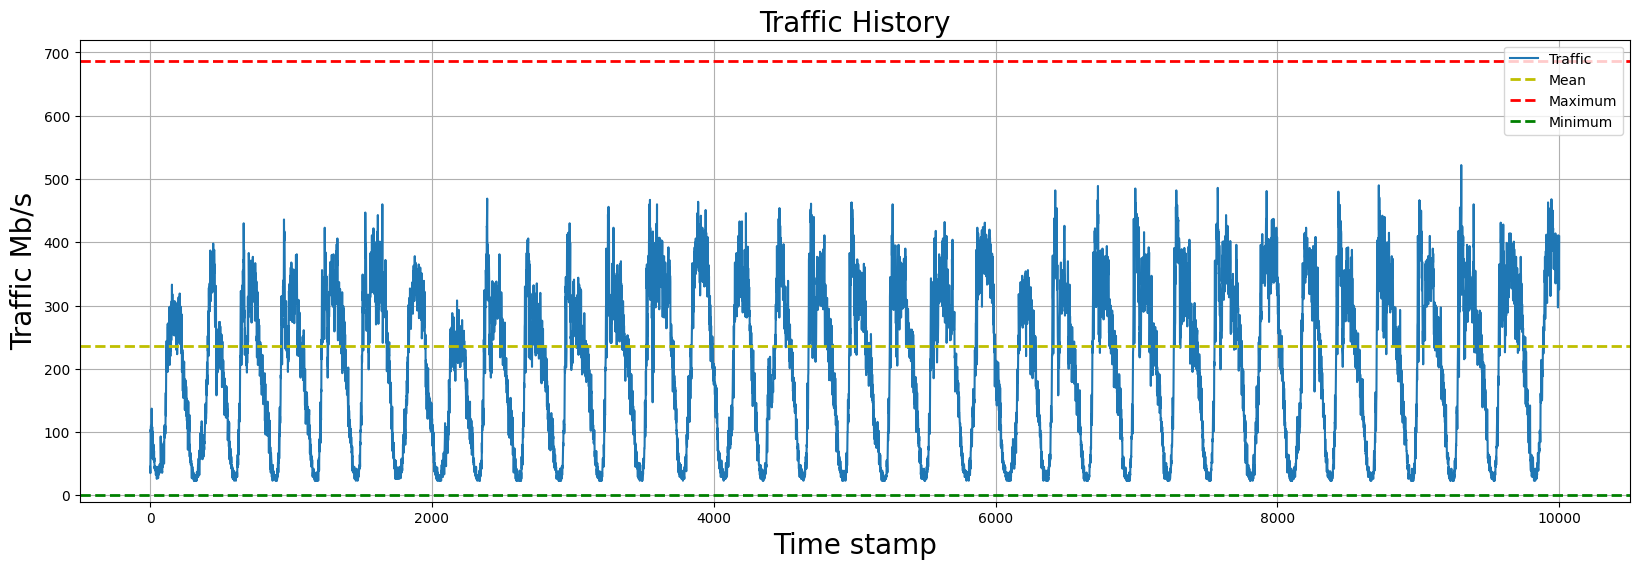

In [11]:
# Let's see some part of data in plot
fig,ax = plt.subplots(figsize=(20,6))
values = df['count'][:10000].values
plt.plot(values,label='Traffic')
mean = df['count'].mean()
max = df['count'].max()
min = df['count'].min()
std = df['count'].std()
plt.axhline(y=mean,color='y', linestyle='--', linewidth=2,label = 'Mean')
plt.axhline(y=max,color='r', linestyle='--', linewidth=2,label = 'Maximum')
plt.axhline(y=min,color='g', linestyle='--', linewidth=2,label = 'Minimum')
plt.xlabel('Time stamp',fontsize=20)
plt.ylabel('Traffic Mb/s',fontsize=20)
plt.title('Traffic History',fontsize=20)
plt.grid()
plt.legend()
plt.show()



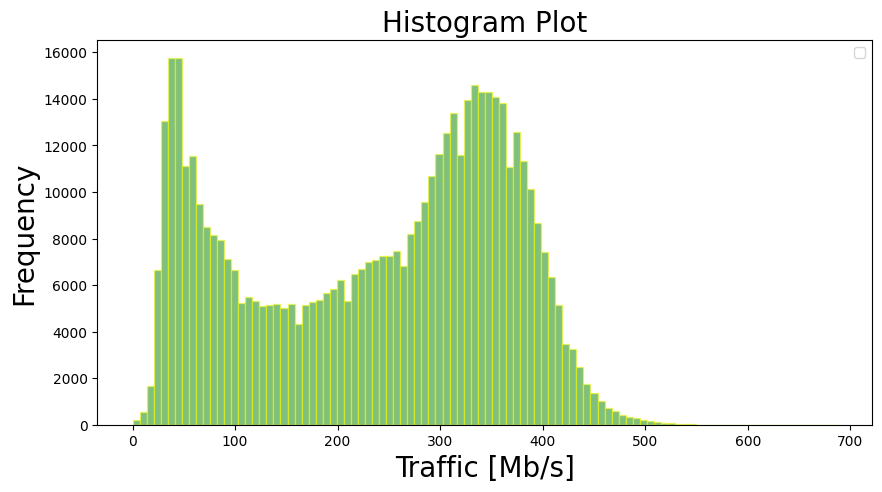

In [12]:
fg, ax = plt.subplots(figsize=(10,5))
plt.hist(df['count'],histtype='barstacked',bins=100,lw=1,ec="yellow", fc="green", alpha=0.5)
plt.xlabel('Traffic [Mb/s]',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Histogram Plot',fontsize=20)
plt.legend()
plt.show()


# Statistic Methods

# Metrics

# Precision, Recall, and F1 Score

### Precision
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Recall
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1 Score
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [13]:
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})

def perfomrance(model_name,y_pred, y_true):

  """
  This funcution aims to return the performance of the model based on the specified metircs.
  Input: model_name (The name of model you ran), y_pred (The predicted value you obtained), y_true(The real values you have from dataset)
  Output: perfomance_table (Shows the metrics you are looking for), Confusion_matrix (Shows TP,TN,FP,FN)

  """

  global performance_table
  precision = metrics.precision_score(y_pred=y_pred, y_true=y_true)
  recall = metrics.recall_score(y_pred=y_pred, y_true=y_true)
  f1_score = metrics.f1_score(y_pred=y_pred, y_true=y_true)
  confusion_matrix = metrics.confusion_matrix(y_pred=y_pred, y_true=y_true)

  new_df_to_add = pd.DataFrame({'Model_name':[model_name],'Precision':[precision],'Recall':[recall],'F1_Score':[f1_score]})
  performance_table = pd.concat([performance_table, new_df_to_add], ignore_index=True)
  return performance_table, confusion_matrix


## **Z-Score method**

The formula for the Z-Score is $Z = \frac{X - \mu}{\sigma}$.

$μ$ and $σ$ denote for mean and standard deviation, respectively.


**Condition:** If we for a point $X$ we have $Z >=Threshold$  $\Rightarrow$ $X$ is $Anomaly $

In [14]:
def Z_score_method(values,threshold):


  X = values
  Z = (X-mean)/std
  print('In the following part you can see the first ten z scores:')
  print(Z[:10])
  print('*'*100)

  # Set Threshold
  if isinstance(threshold, int) or isinstance(threshold,float):
    Threshold = threshold
    result_obtained_from_Z = [1 if z_value>=Threshold else 0 for z_value in Z] # set 1 and 0 for anomaly and normal points, respectiveply
    y_true = df['label'].values
    y_pred = result_obtained_from_Z


    # Let's see its performance
    performance_table, confusion_matrix = perfomrance(model_name=f'Z_score_with_threshold_{Threshold}',y_pred=y_pred, y_true=y_true)

    return y_true,y_pred,performance_table, confusion_matrix

  else:
    number=50
    threshold_list = np.linspace(start=np.min(Z), stop=np.max(Z),num=number) # a loop for threshold for findind the best
    for Threshold in tqdm(threshold_list,f'Please wait. Program is checking {number} different threshold to find the otimal one'):
      result_obtained_from_Z = [1 if z_value>=Threshold else 0 for z_value in Z] # set 1 and 0 for anomaly and normal points, respectiveply
      y_true = df['label'].values
      y_pred = result_obtained_from_Z
      performance_table, confusion_matrix = perfomrance(model_name=f'Z_score_with_threshold_{Threshold}',y_pred=y_pred, y_true=y_true)


    print('hi')
    # Find the best F1_score
    #performance_table_sorted = performance_table.sort_values(by='F1_Score',ascending=False)


    return y_true,y_pred,performance_table

In [15]:
# Call function with one random threshold
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,Z_score_performance_table, confusion_matrix = Z_score_method(values= df['count'].values,threshold=1)
display(Z_score_performance_table)

print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')



In the following part you can see the first ten z scores:
[-1.51555721 -1.56299464 -1.59461959 -1.34161998 -1.04908918 -1.08071413
 -1.00165175 -1.27046384 -1.04118294 -1.13605779]
****************************************************************************************************


,Model_name,Precision,Recall,F1_Score
0,Z_score_with_threshold_1,0.000209,0.092683,0.000416


****************************************************************************************************
Confusion Matrix:
[[TN=434303  FP=91028]
 [FN=186  TP=19]]


In [16]:
# Call function with different thresholds
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,Z_score_performance_table = Z_score_method(values= df['count'].values,threshold='loop')
display(Z_score_performance_table[:10])

In the following part you can see the first ten z scores:
[-1.51555721 -1.56299464 -1.59461959 -1.34161998 -1.04908918 -1.08071413
 -1.00165175 -1.27046384 -1.04118294 -1.13605779]
****************************************************************************************************


Please wait. Program is checking 50 different threshold to find the otimal one: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it]

hi


,Model_name,Precision,Recall,F1_Score
0,Z_score_with_threshold_-1.8713379178707008,0.000390,1.000000,0.000780
1,Z_score_with_threshold_-1.7604892357024957,0.000389,0.995122,0.000777
2,Z_score_with_threshold_-1.6496405535342906,0.000390,0.980488,0.000780
3,Z_score_with_threshold_-1.5387918713660855,0.000379,0.897561,0.000758
4,Z_score_with_threshold_-1.4279431891978804,0.000372,0.829268,0.000743
5,Z_score_with_threshold_-1.3170945070296753,0.000373,0.795122,0.000745
6,Z_score_with_threshold_-1.2062458248614703,0.000371,0.760976,0.000741
7,Z_score_with_threshold_-1.0953971426932652,0.000369,0.731707,0.000738
8,Z_score_with_threshold_-0.9845484605250601,0.000376,0.721951,0.000751
9,Z_score_with_threshold_-0.873699778356855,0.000378,0.707317,0.000757


In [17]:
# Call function with best threshold
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred, Z_score_performance_table, confusion_matrix = Z_score_method(values= df['count'].values,threshold=np.min((df['count'].values-mean)/std))
display(Z_score_performance_table)
print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')
print(' As shown above, Z_score method is terrible since with best threshold, its performance is scaring. It is considering all points as Anomaly.')


In the following part you can see the first ten z scores:
[-1.51555721 -1.56299464 -1.59461959 -1.34161998 -1.04908918 -1.08071413
 -1.00165175 -1.27046384 -1.04118294 -1.13605779]
****************************************************************************************************


,Model_name,Precision,Recall,F1_Score
0,Z_score_with_threshold_-1.8713379178707008,0.00039,1.0,0.00078


****************************************************************************************************
Confusion Matrix:
[[TN=0  FP=525331]
 [FN=0  TP=205]]
 As shown above, Z_score method is terrible since with best threshold, its performance is scaring. It is considering all points as Anomaly.


## **Inquartile Range (IQR)**

The formula for the IRQ is $IQR = Q3 - Q1$.

$Q3$ and $Q1$ denote for 75% and 25% of data, respectively.


**Condition:** For a point called $X$, If we have $X >=Q3+1.5IQR$ or $X <=Q1-1.5IQR $$\Rightarrow$ $X$ is $Anomaly $


In [18]:
def IQR_method(df,threshold):

  X = df['count'].values.copy()
  Q1 = df['count'].quantile(0.25)
  Q3 = df['count'].quantile(0.75)
  IQR = Q3-Q1

  if isinstance(threshold, int) or isinstance(threshold,float):
    result_obtained_from_IQR = [1 if x_value>=(Q3+threshold*IQR) or x_value<=(Q1-threshold*IQR) else 0 for x_value in X]
    y_true = df['label'].values
    y_pred = result_obtained_from_IQR
    # Let's see its performance
    performance_table, confusion_matrix = perfomrance(model_name=f'IQR_with_threshold_{threshold}',y_pred=y_pred, y_true=y_true)
    return y_true,y_pred,performance_table, confusion_matrix

  else:
    number = 50
    for threshold in tqdm(np.linspace(start=0, stop=1.5, num=number),f'Please wait. Program is checking {number} different thresholds to find the otimal one'):
      result_obtained_from_IQR = [1 if x_value>=(Q3+threshold*IQR) or x_value<=(Q1-threshold*IQR) else 0 for x_value in X]
      y_true = df['label'].values
      y_pred = result_obtained_from_IQR
      # Let's see its performance
      performance_table, confusion_matrix = perfomrance(model_name=f'IQR_with_threshold_{threshold}',y_pred=y_pred, y_true=y_true)

    #sort performance
    performance_table = performance_table.sort_values(by='F1_Score',ascending=False)
    return y_true,y_pred,performance_table, confusion_matrix




In [19]:
# Call function with one random threshold
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,IQR_performance_table, confusion_matrix = IQR_method(df,threshold=1.5)
display(IQR_performance_table)
print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model_name,Precision,Recall,F1_Score
0,IQR_with_threshold_1.5,0.0,0.0,0.0


****************************************************************************************************
Confusion Matrix:
[[TN=525331  FP=0]
 [FN=205  TP=0]]


In [20]:
# Call function with different thresholds
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,IQR_performance_table, confusion_matrix = IQR_method(df,threshold='loop')
display(IQR_performance_table[:10])

Please wait. Program is checking 50 different thresholds to find the otimal one:  98%|█████████▊| 49/50 [01:24<00:01,  1.81s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Please wait. Program is checking 50 different thresholds to find the otimal one: 100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


,Model_name,Precision,Recall,F1_Score
15,IQR_with_threshold_0.45918367346938777,0.000603,0.014634,0.001159
14,IQR_with_threshold_0.42857142857142855,0.000539,0.019512,0.001049
13,IQR_with_threshold_0.3979591836734694,0.000528,0.029268,0.001037
9,IQR_with_threshold_0.2755102040816326,0.000459,0.180488,0.000916
7,IQR_with_threshold_0.21428571428571427,0.000440,0.258537,0.000879
8,IQR_with_threshold_0.24489795918367346,0.000436,0.214634,0.000870
6,IQR_with_threshold_0.18367346938775508,0.000401,0.273171,0.000801
10,IQR_with_threshold_0.30612244897959184,0.000392,0.112195,0.000781
4,IQR_with_threshold_0.12244897959183673,0.000367,0.321951,0.000733
5,IQR_with_threshold_0.15306122448979592,0.000358,0.278049,0.000715


In [21]:
# Call function with best threshold
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,IQR_performance_table, confusion_matrix = IQR_method(df,threshold=0.4591)
display(IQR_performance_table)
print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')
print('*'*100)
Z_score_Perforamnce = Z_score_performance_table['F1_Score'].values
print(f'It is better than Z_score with F1_Score: {Z_score_Perforamnce}, but we still need a better one')

,Model_name,Precision,Recall,F1_Score
0,IQR_with_threshold_0.4591,0.000603,0.014634,0.001159


****************************************************************************************************
Confusion Matrix:
[[TN=520361  FP=4970]
 [FN=202  TP=3]]
****************************************************************************************************
It is better than Z_score with F1_Score: [0.00077985], but we still need a better one


## **Exponential Moving Average (EMA)**



The Exponential Moving Average (EMA) is calculated using the following formula:

$$
\text{EMA}_t = \alpha \cdot X_t + (1 - \alpha) \cdot \text{EMA}_{t-1}
$$

where:

- \( $\text{EMA}_t$) is the Exponential Moving Average at time period \( t \).
- \( $\text{X}_t$) is the value of the data point at time period \( t \).
- \( $\alpha\$) is the smoothing factor, calculated as \( \alpha = \frac{2}{N+1} \), where \( N \) is the number of periods.

- \( $\text{EMA}_{t-1}$) is the EMA of the previous period.

### Smoothing Factor ($\alpha\$) and Initial EMA:


$$
\alpha = \frac{2}{N + 1}
$$

where \(N\) is the number of periods.


Condition

$$
\text{EMA}_0 = \frac{1}{N} \sum_{i=1}^{N} X_i
$$

where \(X_i\) are the data points.



**Condition:** For a point $\text{X}_t$, if we have |$\text{X}_t - \text{EMA}_t| >=Threshold$   $\Rightarrow$ $\text{X}_t$ is $Anomaly $

In [105]:
# In this method, instead of just having threshold to find, we need to find the best N as Period
def EMA_method(df,N,threshold):

  if isinstance(N, int) and (isinstance(threshold, int) or isinstance(threshold, float)):
    X = df['count']
    All_EMA = X.ewm(span=N, adjust=False,ignore_na=True).mean()
    result_obtained_from_EMA = [1 if abs(x_value-All_EMA[index])>=threshold  else 0 for index,x_value in enumerate(X)]
    y_true = df['label'].values
    y_pred = result_obtained_from_EMA
    # Let's see its performance
    performance_table, confusion_matrix = perfomrance(model_name=f'EMA_with_threshold_{threshold}_N_{N}',y_pred=y_pred, y_true=y_true)
    return y_true,y_pred,performance_table, confusion_matrix

  else:
    for N in tqdm(range(1,50), 'Please wait.'):
      for threshold in range(1,3):
        X = df['count']
        All_EMA = X.ewm(span=N, adjust=False,ignore_na=True).mean()
        result_obtained_from_EMA = [1 if abs(x_value-All_EMA[index])>=threshold  else 0 for index,x_value in enumerate(X)]
        y_true = df['label'].values
        y_pred = result_obtained_from_EMA
        # Let's see its performance
        performance_table, confusion_matrix = perfomrance(model_name=f'EMA_with_threshold_{threshold}_N_{N}',y_pred=y_pred, y_true=y_true)



    #sort performance
    performance_table = performance_table.sort_values(by='F1_Score',ascending=False)
    return y_true,y_pred,performance_table, confusion_matrix

In [103]:
# Call function with random threshold and N
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,EMA_performance_table, confusion_matrix = EMA_method(df=df,N=3,threshold=3)
display(EMA_performance_table)
print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')
print('*'*100)

,Model_name,Precision,Recall,F1_Score
0,EMA_with_threshold_3_N_3,0.000401,0.770732,0.000801


****************************************************************************************************
Confusion Matrix:
[[TN=131218  FP=394113]
 [FN=47  TP=158]]
****************************************************************************************************


In [106]:
# Call function with different thresholds and N
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,EMA_performance_table, confusion_matrix = EMA_method(df=df,N='loop',threshold='loop')
display(EMA_performance_table)


Please wait.: 100%|██████████| 49/49 [05:21<00:00,  6.56s/it]


,Model_name,Precision,Recall,F1_Score
16,EMA_with_threshold_1_N_9,0.000402,0.985366,0.000803
15,EMA_with_threshold_2_N_8,0.000401,0.931707,0.000801
13,EMA_with_threshold_2_N_7,0.000400,0.921951,0.000799
17,EMA_with_threshold_2_N_9,0.000400,0.936585,0.000799
23,EMA_with_threshold_2_N_12,0.000399,0.951220,0.000798
...,...,...,...,...
4,EMA_with_threshold_1_N_3,0.000381,0.892683,0.000761
7,EMA_with_threshold_2_N_4,0.000378,0.834146,0.000756
5,EMA_with_threshold_2_N_3,0.000378,0.804878,0.000756
1,EMA_with_threshold_2_N_1,0.000000,0.000000,0.000000


In [107]:
# Call function with best threshold and N
performance_table = pd.DataFrame({'Model_name':[],'Precision':[],'Recall':[],'F1_Score':[]})
y_true,y_pred,EMA_performance_table, confusion_matrix = EMA_method(df=df,N=9,threshold=1)
display(EMA_performance_table)
print('*'*100)
print('Confusion Matrix:')
print(f'[[TN={confusion_matrix[0][0]}  FP={confusion_matrix[0][1]}]')
print(f' [FN={confusion_matrix[1][0]}  TP={confusion_matrix[1][1]}]]')
print('*'*100)
IQR_Perforamnce = IQR_performance_table['F1_Score'].values
print(f'It is not better than IQR with F1_Score: {IQR_Perforamnce}, So we still need a better one')

,Model_name,Precision,Recall,F1_Score
0,EMA_with_threshold_1_N_9,0.000402,0.985366,0.000803


****************************************************************************************************
Confusion Matrix:
[[TN=22483  FP=502848]
 [FN=3  TP=202]]
****************************************************************************************************
It is not better than IQR with F1_Score: [0.00115875], So we still need a better one
